# Homework day 1 - Bryn Lampe

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from random import uniform
import quantecon as qe
from numpy import *
from numpy.random import rand, randn
from numpy.fft import fft, ifft
from numpy.lib.scimath import *
from numba import jitclass, float64, jit

# Matlibplot

### Exercise 1

Plot the function

$$
f(x) = \cos(\pi \theta x) \exp(-x)
$$

over the interval $ [0, 5] $ for each $ \theta $ in `np.linspace(0, 2, 10)`.

Place all the curves in the same figure.

The output should look like this

![matplotlib_ex1.png](figures/matplotlib_ex1.png)  

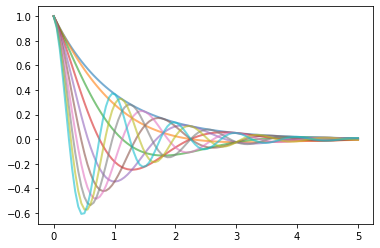

In [45]:
def f(x, θ):
    return np.cos(3.14 * θ * x) * np.exp( - x )


fig, ax = plt.subplots()

x = np.linspace(0, 5, 100)
θgrid = np.linspace(0, 2, 10)

for θ in θgrid:
    y = f(x, θ)
    ax.plot(x, y, linewidth=2, alpha=0.6)


plt.show()

### Exercise 2

Here's an implementation of the [empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function).

The ``__call__`` method allows the user to evaluation the class as if it was a function.

For each ``x``, this method gives the fraction of the sample ``observations`` that is ``<= x``.

In [46]:
class ECDF:

    def __init__(self, observations):
        self.observations = observations

    def __call__(self, x):
        counter = 0.0
        for obs in self.observations:
            if obs <= x:
                counter += 1
        return counter / len(self.observations)

Your task is to

1. Make the `__call__` method more efficient using NumPy.  
1. Add a method that plots the ECDF over $ [a, b] $, where $ a $ and $ b $ are method parameters.  

In [47]:
class ECDF:

    def __init__(self, observations):
        self.observations = observations

    def __call__(self, x):
        obs = self.observations[self.observations < x]
        count = len(obs)
        return count / len(self.observations)
    
F = ECDF(np.random.uniform(0, 1, size=1_000_000))
F(0.5)  # Should be close to 0.5

0.499768

# Numpy

### Exercise 1

Consider the polynomial expression


<a id='equation-np-polynom'></a>
$$
p(x) = a_0 + a_1 x + a_2 x^2 + \cdots a_N x^N = \sum_{n=0}^N a_n x^n \tag{1}
$$

[Earlier](python_essentials.ipynb#pyess-ex2), you wrote a simple function `p(x, coeff)` to evaluate [(1)](#equation-np-polynom) without considering efficiency.

Now write a new function that does the same job, but uses NumPy arrays and array operations for its computations, rather than any form of Python loop.

(Such functionality is already implemented as `np.poly1d`, but for the sake of the exercise don’t use this class)

- Hint: Use `np.cumprod()`  



<a id='np-ex2'></a>

In [48]:
N = 10
x = 2
a = np.random.rand(N+1)

def polynomial_fn(a,x,N):
    x_vec = x * np.ones(N)
    x_first = np.ones(1)
    x_sequence = np.append(x_first, x_vec)
    product = a * x_sequence.cumprod()
    p_x = product.sum()
    return(p_x)

p = polynomial_fn(a, x, N)
print(p)



1269.8075828399149


### Exercise 2

Let `q` be a NumPy array of length `n` with `q.sum() == 1`.

Suppose that `q` represents a [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function).

We wish to generate a discrete random variable $ x $ such that $ \mathbb P\{x = i\} = q_i $.

In other words, `x` takes values in `range(len(q))` and `x = i` with probability `q[i]`.

The standard (inverse transform) algorithm is as follows:

- Divide the unit interval $ [0, 1] $ into $ n $ subintervals $ I_0, I_1, \ldots, I_{n-1} $ such that the length of $ I_i $ is $ q_i $.  
- Draw a uniform random variable $ U $ on $ [0, 1] $ and return the $ i $ such that $ U \in I_i $.  


The probability of drawing $ i $ is the length of $ I_i $, which is equal to $ q_i $.

We can implement the algorithm as follows

In [49]:

q = [0.2, 0.4, 0.4]
U = uniform(0, 1) # moved this outside to test functions

def sample(q, U):
    "This is the example function"
    a = 0.0

    for i in range(len(q)):
        if a < U <= a + q[i]:
            return i
        a = a + q[i]
        

def sample2(q, U):
    "This is the vectorised version of sample"
    interval = np.cumsum(q)
    location = np.searchsorted(interval, U)
    return location
        
print(sample2(q,U) == sample(q, U))


class discreteRV:
    
    def __init__(self, q=[0.25,0.75]):
 
        self.q = q

            
    def draw(self,k):
        "This is the function extended to sample k times"
        q = self.q
        U = np.random.uniform(0, 1, k)
        interval = np.cumsum(q)
        location = np.searchsorted(interval, U)
        return location
    
    
drv =  discreteRV(q = [0.1,0.2,0.3,0.4])
print(drv.draw(100))


True
[2 2 3 1 1 2 2 2 2 2 0 3 3 3 0 0 2 1 3 2 2 3 1 2 2 3 2 0 2 3 2 2 3 3 3 3 0
 3 1 1 0 0 2 3 2 0 1 1 2 2 2 2 2 2 1 3 3 3 3 1 3 3 3 0 0 0 1 1 2 3 3 3 3 3
 2 2 2 2 3 0 3 1 1 2 2 3 3 3 3 3 3 3 3 3 2 2 1 0 2 1]


# Parallelisation

### Exercise 1

In [an earlier exercise](numba.ipynb#speed-ex1), we used Numba to accelerate an
effort to compute the constant $ \pi $ by Monte Carlo.

Now try adding parallelization and see if you get further speed gains.

You should not expect huge gains here because, while there are many
independent tasks (draw point and test if in circle), each one has low
execution time.

Generally speaking, parallelization is less effective when the individual
tasks to be parallelized are very small relative to total execution time.

This is due to overheads associated with spreading all of these small tasks across multiple CPUs.

Nevertheless, with suitable hardware, it is possible to get nontrivial speed gains in this exercise.

For the size of the Monte Carlo simulation, use something substantial, such as
`n = 100_000_000`.

In [50]:
n = 100_000_000
@jit
def approx_pi2(n):
    'just jit'
    count = 0
    for i in range(n):
        u, v = np.random.uniform(0, 1), np.random.uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1
    return count/n * 4



print(approx_pi2(n))

3.14136224


# Numba

### Exercise 1

[An exercise](https://python.quantecon.org/python_by_example.html#Exercise-3) in one of the QuantEcon lectures considers how to approximate $ \pi $ by
Monte Carlo.

Use the same idea here, but make the code efficient using Numba.

Compare speed with and without Numba when the sample size is large.


<a id='speed-ex2'></a>

In [51]:
n = 100000

def approx_pi(n):
    'vectorised montecolaro estimation of π'
    u, v = np.random.uniform(0, 1, n), np.random.uniform(0, 1, n)
    d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
    d = d[d < 0.5]
    count = len(d)

    return 4* count / n

print(approx_pi(n))



3.13104


### Exercise 2

Later we’ll learn about finite-state Markov chains.

For now, let’s just concentrate on simulating a very simple example of such a chain.

Suppose that the volatility of returns on an asset can be in one of two regimes — high or low.

The transition probabilities across states are as follows

![nfs_ex1.png](figures/nfs_ex1.png)  

For example, let the period length be one day, and suppose the current state is high.

We see from the graph that the state tomorrow will be

- high with probability 0.8  
- low with probability 0.2  


Your task is to simulate a sequence of daily volatility states according to this rule.

Set the length of the sequence to `n = 1_000_000` and start in the high state.

Implement a pure Python version and a Numba version, and compare speeds.

To test your code, evaluate the fraction of time that the chain spends in the low state.

If your code is correct, it should be about 2/3.

Hints:

- Represent the low state as 0 and the high state as 1.  
- If you want to store integers in a NumPy array and then apply JIT compilation, use `x = np.empty(n, dtype=np.int_)`. 

In [52]:
n = 1000000
x = np.zeros(n)
transition_mat = np.array([0.9, 0.1, 0.2, 0.8])
transition_mat.shape = (2,2)


def asset_return(x,transition_mat):
    x[0] = 1
    
    for i in range(len(x)-1):
        U = np.random.uniform(0, 1)
        x_current = x[i]
        
        if x_current == 0:
            transition_vec = transition_mat[0,:]
        if x_current == 1:
            transition_vec = transition_mat[1,:]  
        
        interval = np.cumsum(transition_vec) # from previous example
        location = np.searchsorted(interval, U)  
        x[i+1] = location

    return x


@jit
def asset_return2(x,transition_mat):
    x[0] = 1
    
    for i in range(len(x)-1):
        U = np.random.uniform(0, 1)
        x_current = x[i]
        
        if x_current == 0:
            transition_vec = transition_mat[0,:]
            if U < transition_vec[0]: # could use the vectorisation trick from before,
                                      # but jit is will speed this up so you can avoid
                                      # vectorisation
                x_new = 0
            if U > transition_vec[0]:
                x_new = 1
                
        if x_current == 1:
            transition_vec = transition_mat[1,:]
            if U < transition_vec[0]:
                x_new = 0
            if U > transition_vec[0]:
                x_new = 1
            
        
        x[i+1] = x_new

    return x
        

qe.tic()
print(asset_return2(x,transition_mat))
print(np.mean(asset_return2(x,transition_mat)))
time2 = qe.toc()

[1. 0. 1. ... 1. 1. 1.]
0.331045
TOC: Elapsed: 0:00:0.16
